In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import cv2

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits
    
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

import matplotlib.pyplot as plt
import cv2
import numpy as np


def visualize_multiple_gradcams(model, image_paths, device, transform, num_images=2):
    results = []
    
    for i, img_path in enumerate(image_paths[:num_images]):
        image, cam, heatmap, blended = visualize_gradcam(model, img_path, device, transform)
        results.append((image, cam, heatmap, blended))
    
    # Create figure with better layout
    fig, axes = plt.subplots(num_images, 4, figsize=(18, 5*num_images))
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    
    for i, (image, cam, heatmap, blended) in enumerate(results):
        # Original Image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Original Image {i+1}", fontsize=12)
        axes[i, 0].axis('off')
        
        # GradCAM
        axes[i, 1].imshow(cam, cmap='inferno')
        axes[i, 1].set_title(f"GradCAM {i+1}", fontsize=12)
        axes[i, 1].axis('off')
        
        # Heatmap
        axes[i, 2].imshow(heatmap)
        axes[i, 2].set_title(f"Heatmap {i+1}", fontsize=12)
        axes[i, 2].axis('off')
        
        # Blended
        axes[i, 3].imshow(blended)
        axes[i, 3].set_title(f"Blended {i+1}", fontsize=12)
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results

In [85]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Forward hook
        def forward_hook(module, input, output):
            self.activations = output
            return None  # Important for some PyTorch versions
        
        # Backward hook
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
            return None  # Important for some PyTorch versions
        
        self.forward_hook = target_layer.register_forward_hook(forward_hook)
        self.backward_hook = target_layer.register_backward_hook(backward_hook)
    
    def __del__(self):
        self.forward_hook.remove()
        self.backward_hook.remove()
    
    def forward(self, x):
        return self.model(x)
    
    def generate_cam(self, x, target_class=None):
        # Forward pass
        output = self.forward(x)
        
        if target_class is None:
            target_class = 0 if torch.sigmoid(output).item() < 0.5 else 1
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass - CRITICAL FIX FOR BINARY CLASSIFICATION
        one_hot = torch.zeros_like(output)
        one_hot[0][0] = output  # Backprop through the actual output value
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Check if gradients were captured
        if self.gradients is None:
            raise RuntimeError("No gradients captured! Check hook registration.")
        
        # Pool gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Compute CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=False)
        
        # Detach and process
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam

In [86]:
def verify_gradcam_flow(model, device):
    # Create test input
    test_input = torch.randn(1, 3, 512, 1024).to(device)
    
    # Initialize GradCAM
    target_layer = model.vgg16.features[-1]
    gradcam = GradCAM(model, target_layer)
    
    # Forward pass
    output = gradcam.forward(test_input)
    print(f"Model output: {output.item():.4f}")
    
    # Backward pass
    output.backward()
    
    # Verify activations and gradients
    print(f"Activations shape: {gradcam.activations.shape if gradcam.activations is not None else 'None'}")
    print(f"Gradients shape: {gradcam.gradients.shape if gradcam.gradients is not None else 'None'}")
    print(f"Gradients mean: {gradcam.gradients.mean().item() if gradcam.gradients is not None else 'None'}")
    
    del gradcam

In [87]:
def find_best_target_layer(model):
    # Try different layers
    candidate_layers = [
        model.vgg16.features[24],  # Last conv before pooling
        model.vgg16.features[17],  # Middle conv
        model.vgg16.features[10]   # Early conv
    ]
    
    for i, layer in enumerate(candidate_layers):
        print(f"\nTesting layer {i}:")
        verify_gradcam_flow(model, device)

In [88]:
def visualize_gradcam(model, image_path, device, transform):
    # Load image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Try multiple target layers if first fails
    target_layers = [
        model.vgg16.features[-1],  # Default last layer
        model.vgg16.features[24],  # Last conv before pooling
        model.vgg16.features[17]   # Middle conv layer
    ]
    
    for i, layer in enumerate(target_layers):
        print(f"\nAttempting with target layer {i}")
        gradcam = GradCAM(model, layer)
        try:
            cam = gradcam.generate_cam(input_tensor)
            if cam.max() > 0.1:  # Only accept meaningful CAMs
                print(f"Valid CAM found with layer {i}")
                break
        except Exception as e:
            print(f"Layer {i} failed: {str(e)}")
        del gradcam
    
    # Generate visualizations
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_INFERNO)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, image.size)
    
    # Create blended image
    image_np = np.array(image)
    blended = cv2.addWeighted(image_np, 0.3, heatmap, 0.7, 0)
    
    return image, cam, heatmap, blended

In [89]:
verify_gradcam_flow(model, device)

Model output: -2.1521
Activations shape: torch.Size([1, 512, 16, 32])
Gradients shape: torch.Size([1, 512, 16, 32])
Gradients mean: -0.00013696032692678273



Attempting with target layer 0
Valid CAM found with layer 0

Attempting with target layer 0
Valid CAM found with layer 0

Attempting with target layer 0
Valid CAM found with layer 0

Attempting with target layer 0
Valid CAM found with layer 0

Attempting with target layer 0
Valid CAM found with layer 0


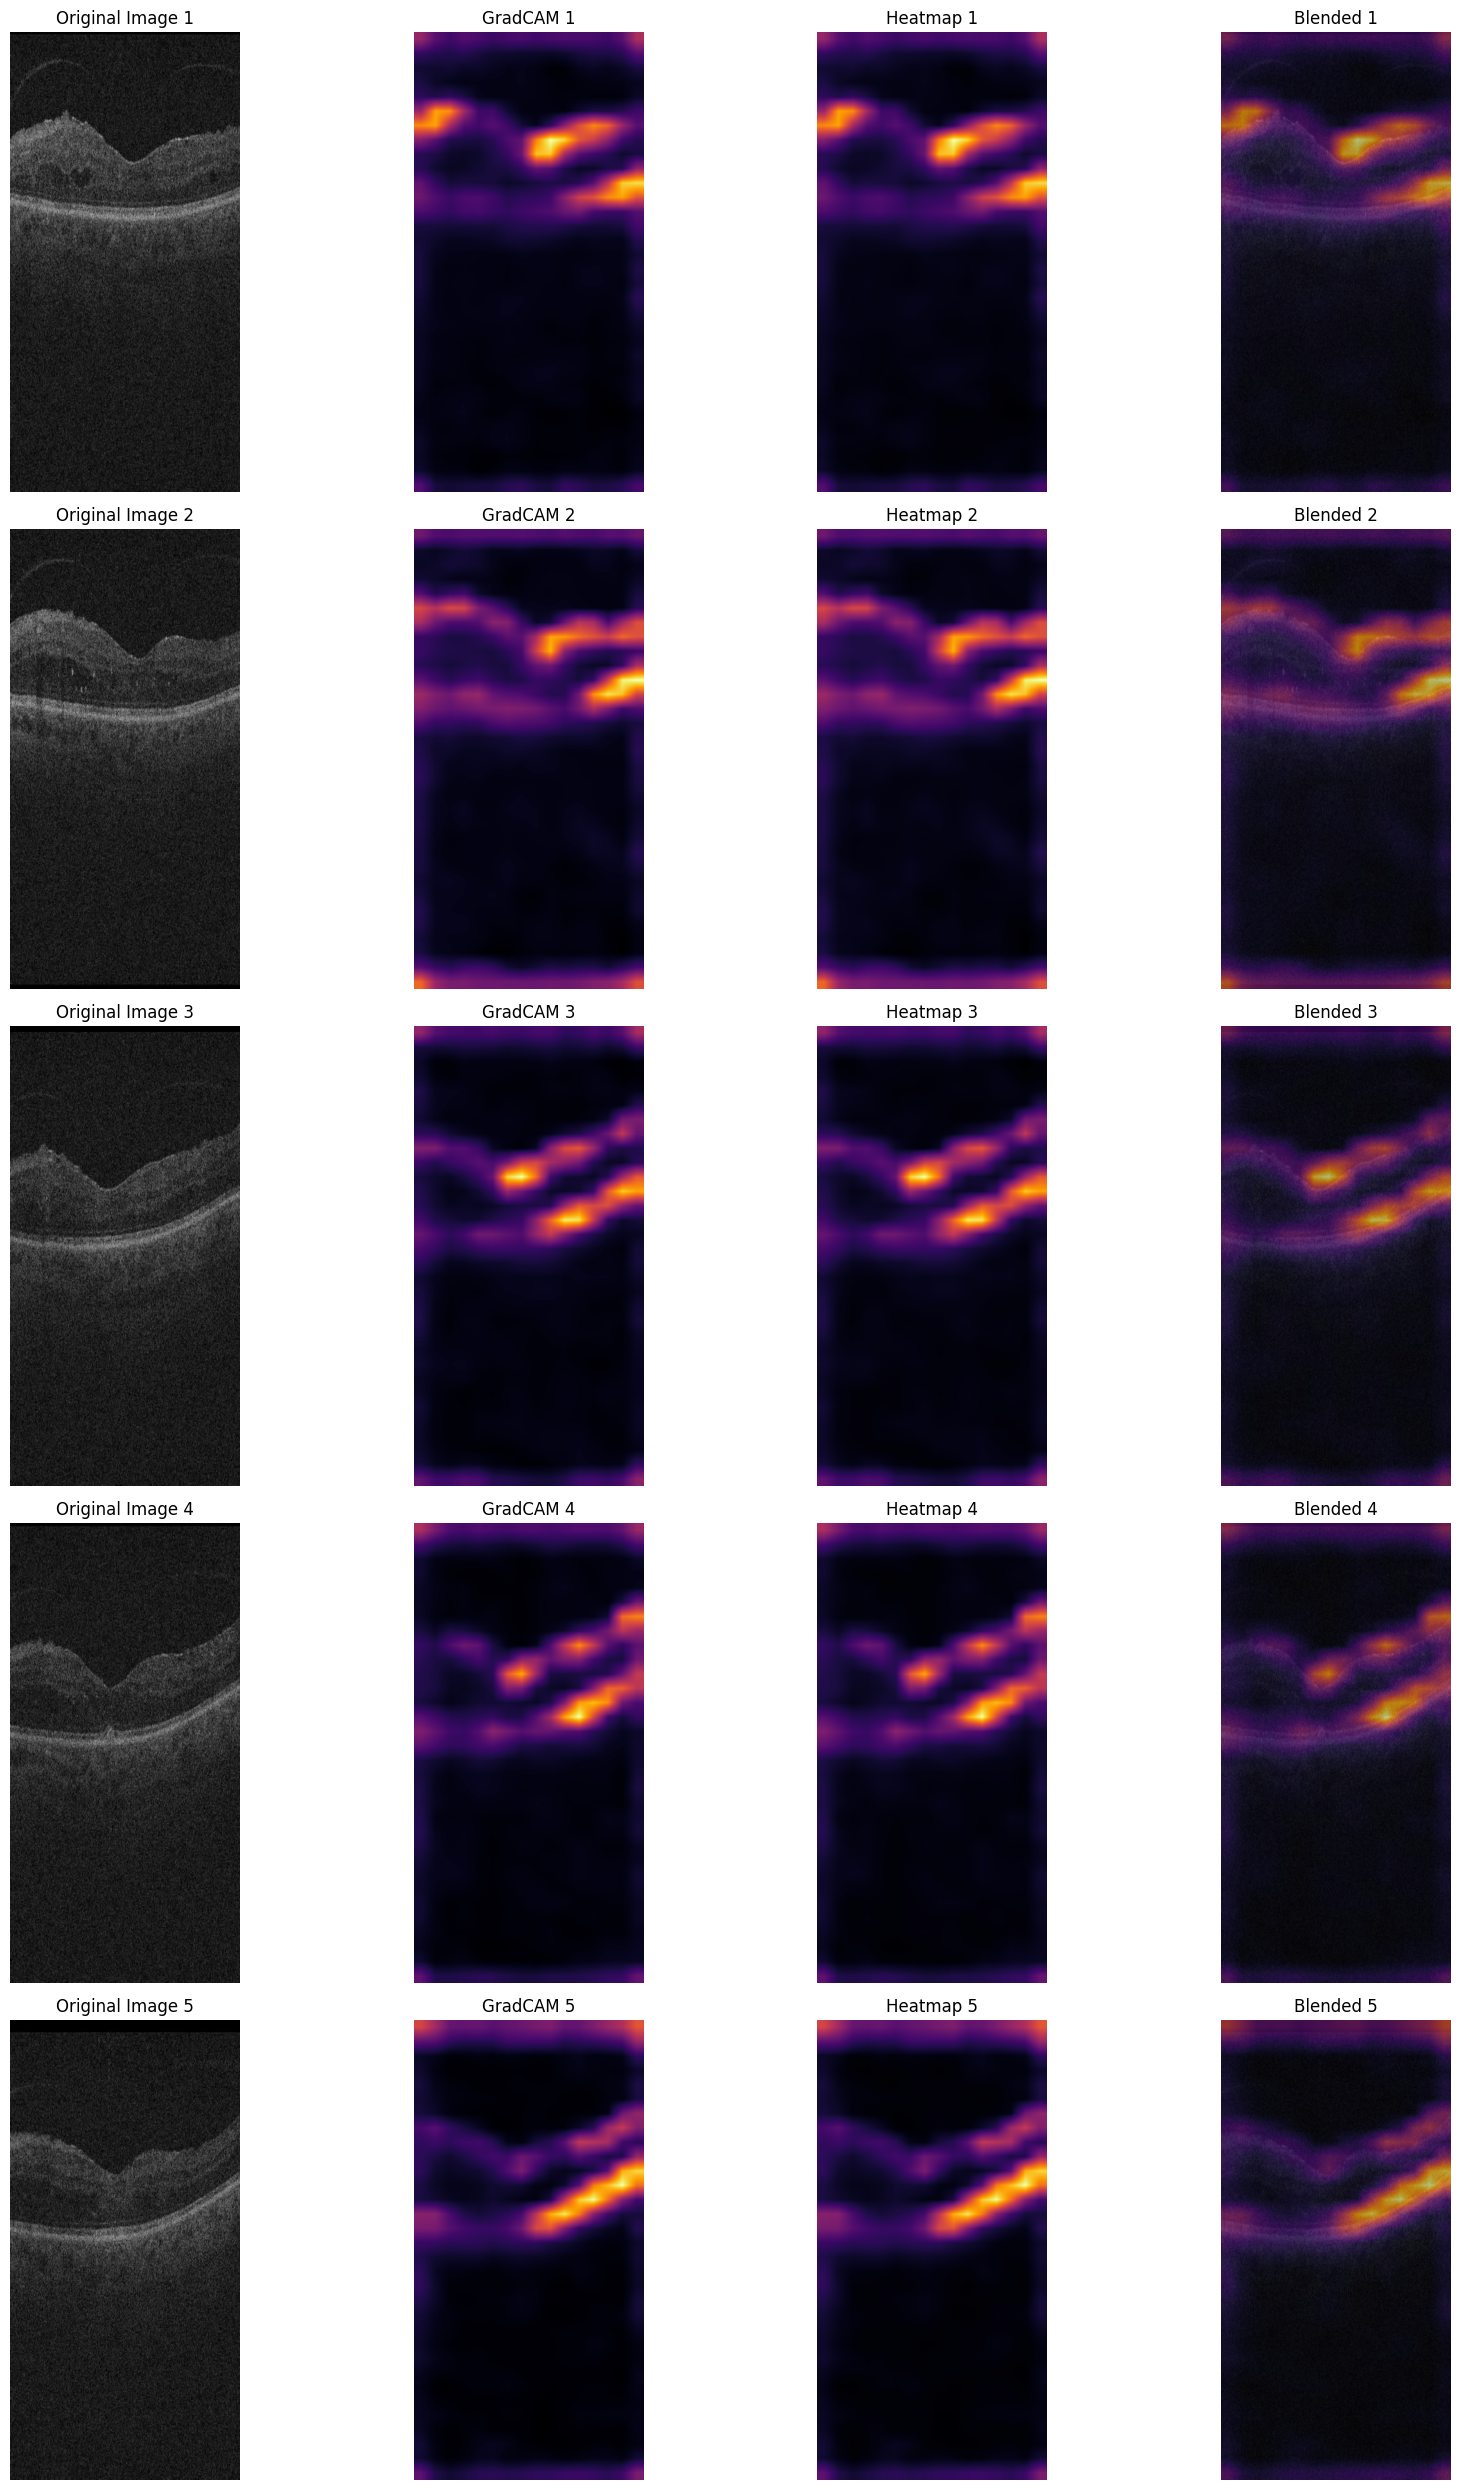

In [90]:
results = visualize_multiple_gradcams(model, all_image_paths, device, transform, num_images=5)